In [1]:
from pickStocksByCorrelation import pickStocksByCorrelation
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


from pypfopt.risk_models import CovarianceShrinkage, sample_cov, exp_cov
from pypfopt.risk_models import risk_matrix

In [88]:
sp_500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp_500['Symbol'] = [s.replace('.', '-') for s in sp_500['Symbol']]
sp_500_tickers = list(sp_500['Symbol'])

In [89]:
prices = yf.download(sp_500_tickers, period = "20y")["Close"].dropna(axis=1, how="any")
prices

[*********************100%***********************]  503 of 503 completed


Ticker,A,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,...,WRB,WSM,WST,WTW,WY,WYNN,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2005-04-25,12.818909,14.437413,15.348874,30.020000,21.069931,13.134642,21.952208,32.959999,22.592033,15.922929,...,4.522555,10.907763,10.963020,58.108353,11.737325,29.630009,30.746840,11.973795,69.624237,47.810001
2005-04-26,12.830934,14.488796,15.138125,29.559999,20.957392,13.116008,21.513453,31.920000,22.442566,15.814145,...,4.512709,10.862930,10.791787,58.074577,11.739187,30.434752,30.393015,11.934067,69.328949,47.549999
2005-04-27,12.764794,14.648965,15.081935,29.225000,20.857353,13.389262,21.636705,31.700001,22.583244,16.004520,...,4.581634,11.007043,11.121724,57.331097,12.377685,29.538177,29.936632,11.889374,70.979019,47.820000
2005-04-28,12.416065,14.534121,15.187302,29.235001,20.957392,13.432735,21.345839,31.309999,22.433779,15.864008,...,4.550690,10.782865,10.879492,55.303459,12.217121,28.895466,28.716204,11.693193,70.605576,46.619999
2005-04-29,12.476187,14.857501,15.243495,29.735001,21.326277,11.172205,21.414862,31.830000,22.728317,15.963721,...,4.571790,10.725221,11.000610,56.520031,12.808929,28.593000,29.244371,11.660918,70.709824,47.759998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,102.480003,130.979996,282.350006,348.799988,176.270004,47.820000,293.279999,259.470001,98.650002,107.709999,...,68.800003,139.210007,201.899994,321.000000,25.809999,74.769997,106.919998,143.309998,97.919998,226.729996
2025-04-21,100.260002,129.889999,279.230011,343.220001,174.990005,48.090000,284.850006,254.270004,96.480003,105.529999,...,67.330002,137.869995,205.880005,315.760010,24.690001,74.959999,105.349998,140.509995,96.169998,222.050003
2025-04-22,102.809998,131.729996,283.959991,349.910004,178.500000,48.540001,292.890015,261.140015,99.150002,108.150002,...,70.849998,141.929993,215.130005,324.679993,25.260000,76.970001,108.300003,145.050003,97.440002,227.199997


In [95]:
returns = prices.pct_change(fill_method=None).dropna()
returns

Ticker,A,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,...,WRB,WSM,WST,WTW,WY,WYNN,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2005-04-26,0.000938,0.003559,-0.013731,-0.015323,-0.005341,-0.001419,-0.019987,-0.031553,-0.006616,-0.006832,...,-0.002177,-0.004110,-0.015619,-0.000581,0.000159,0.027160,-0.011508,-0.003318,-0.004241,-0.005438
2005-04-27,-0.005155,0.011055,-0.003712,-0.011333,-0.004773,0.020834,0.005729,-0.006892,0.006268,0.012038,...,0.015273,0.013266,0.030573,-0.012802,0.054390,-0.029459,-0.015016,-0.003745,0.023801,0.005678
2005-04-28,-0.027320,-0.007840,0.006986,0.000342,0.004796,0.003247,-0.013443,-0.012303,-0.006618,-0.008780,...,-0.006754,-0.020367,-0.021780,-0.035367,-0.012972,-0.021759,-0.040767,-0.016500,-0.005261,-0.025094
2005-04-29,0.004842,0.022250,0.003700,0.017103,0.017602,-0.168285,0.003234,0.016608,0.013129,0.006286,...,0.004637,-0.005346,0.011133,0.021998,0.048441,-0.010468,0.018393,-0.002760,0.001476,0.024453
2005-05-02,0.010602,0.004476,0.012443,-0.039011,-0.007623,0.035575,0.008748,0.018536,0.008511,0.004259,...,-0.003385,0.017617,0.026955,0.031689,-0.002186,-0.043823,0.012450,0.004472,-0.006018,-0.047529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,-0.002142,0.009869,-0.010132,0.013394,0.001933,0.036636,-0.002924,-0.002652,0.006633,0.016900,...,0.005113,0.016428,-0.034572,-0.011486,0.008597,0.014105,0.026202,0.005190,0.010109,0.008765
2025-04-21,-0.021663,-0.008322,-0.011050,-0.015998,-0.007262,0.005646,-0.028744,-0.020041,-0.021997,-0.020240,...,-0.021366,-0.009626,0.019713,-0.016324,-0.043394,0.002541,-0.014684,-0.019538,-0.017872,-0.020641
2025-04-22,0.025434,0.014166,0.016939,0.019492,0.020058,0.009357,0.028225,0.027019,0.027674,0.024827,...,0.052280,0.029448,0.044929,0.028249,0.023086,0.026814,0.028002,0.032311,0.013206,0.023193


In [ ]:
highCorrTickers = pickStocksByCorrelation(returns.corr(), 10, "high")[0]
mixedCorrTickers = pickStocksByCorrelation(returns.corr(), 10, "mixed")[0]
lowCorrTickers = pickStocksByCorrelation(returns.corr(), 10, "low")[0]

print("High Correlation: ", highCorrTickers)
print("Mixed Correlation: ", mixedCorrTickers)
print("Low Correlation: ", lowCorrTickers)

High Correlation:  ['AEE', 'AEP', 'CMS', 'D', 'DTE', 'DUK', 'ED', 'ES', 'EVRG', 'LNT']
Mixed Correlation:  ['PNW', 'TKO', 'AEP', 'DUK', 'SO', 'CNC', 'DVA', 'ED', 'WEC', 'AEE']
Low Correlation:  ['PNW', 'TKO', 'AEP', 'DUK', 'SO', 'CNC', 'DVA', 'ED', 'WEC', 'AEE']


In [99]:
pd.DataFrame({
    "highCorrelationPortfolio": highCorrTickers,
    "mixedCorrelationPortfolio": mixedCorrTickers,
    "lowCorrelationPortfolio": lowCorrTickers
}).to_excel("portfolioTickers.xlsx", index=False)

Text(0.5, 1.0, 'Low Correlation portfolio')

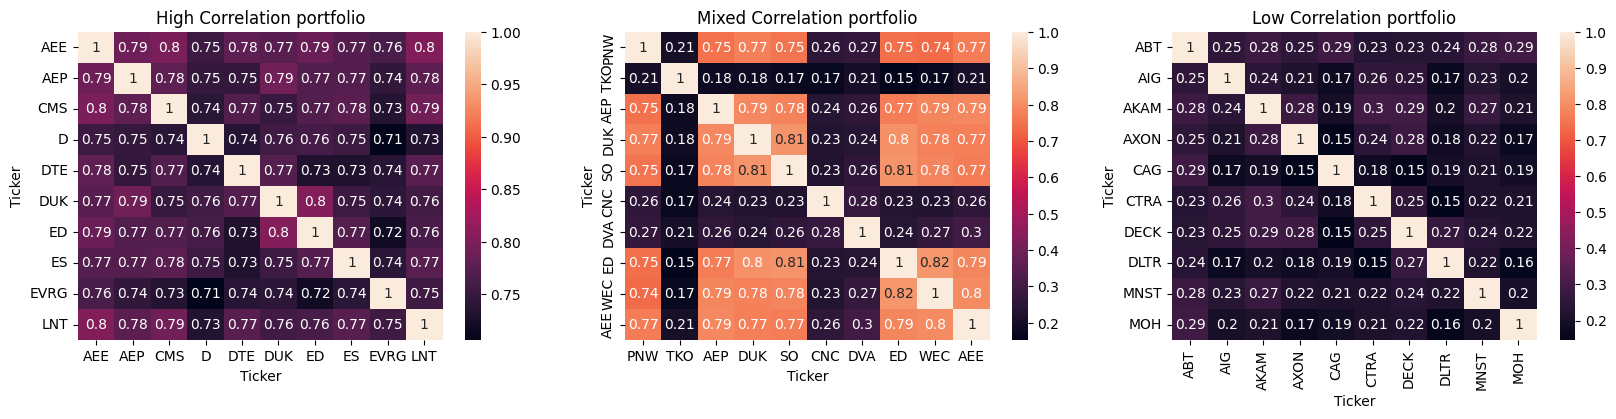

In [114]:
fig, ax = plt.subplots(1, 3, figsize = (20,4))
sns.heatmap(returns[highCorrTickers].corr(), annot=True, ax=ax[0])
ax[0].set_title("High Correlation portfolio")
sns.heatmap(returns[mixedCorrTickers].corr(), annot=True, ax=ax[1])
ax[1].set_title("Mixed Correlation portfolio")
sns.heatmap(returns[lowCorrTickers].corr(), annot=True, ax=ax[2])
ax[2].set_title("Low Correlation portfolio")

In [3]:
prices = yf.download(["AAPL", "SPY", "NVDA", "JPM"])["Close"].dropna()
prices

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,JPM,NVDA,SPY
Date,,,,
1999-01-22,0.291532,22.569088,0.037612,77.050583
1999-01-25,0.296234,23.373726,0.041552,77.836433
1999-01-26,0.304698,23.314852,0.038328,79.250938
1999-01-27,0.301876,22.961594,0.038209,78.327530
1999-01-28,0.307519,23.118595,0.038089,79.643822
...,...,...,...,...
2025-04-16,194.270004,229.610001,104.489998,525.659973
2025-04-17,196.979996,231.960007,101.489998,526.409973
2025-04-21,193.160004,228.990005,96.910004,513.880005
